# Get the Data

## Download the Data

In [144]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [145]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Take a Quick Look at the Data Structure

In [146]:
# getting the data
fetch_housing_data()

#loading the data
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [147]:
# getting a quick description of the data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [148]:
# finding out what categories exist for ocean_proximity
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [149]:
# getting a statistical summary of the numerical attributes
housing.describe()

/Users/Dayo/anaconda/envs/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,NaN,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,NaN,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,NaN,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


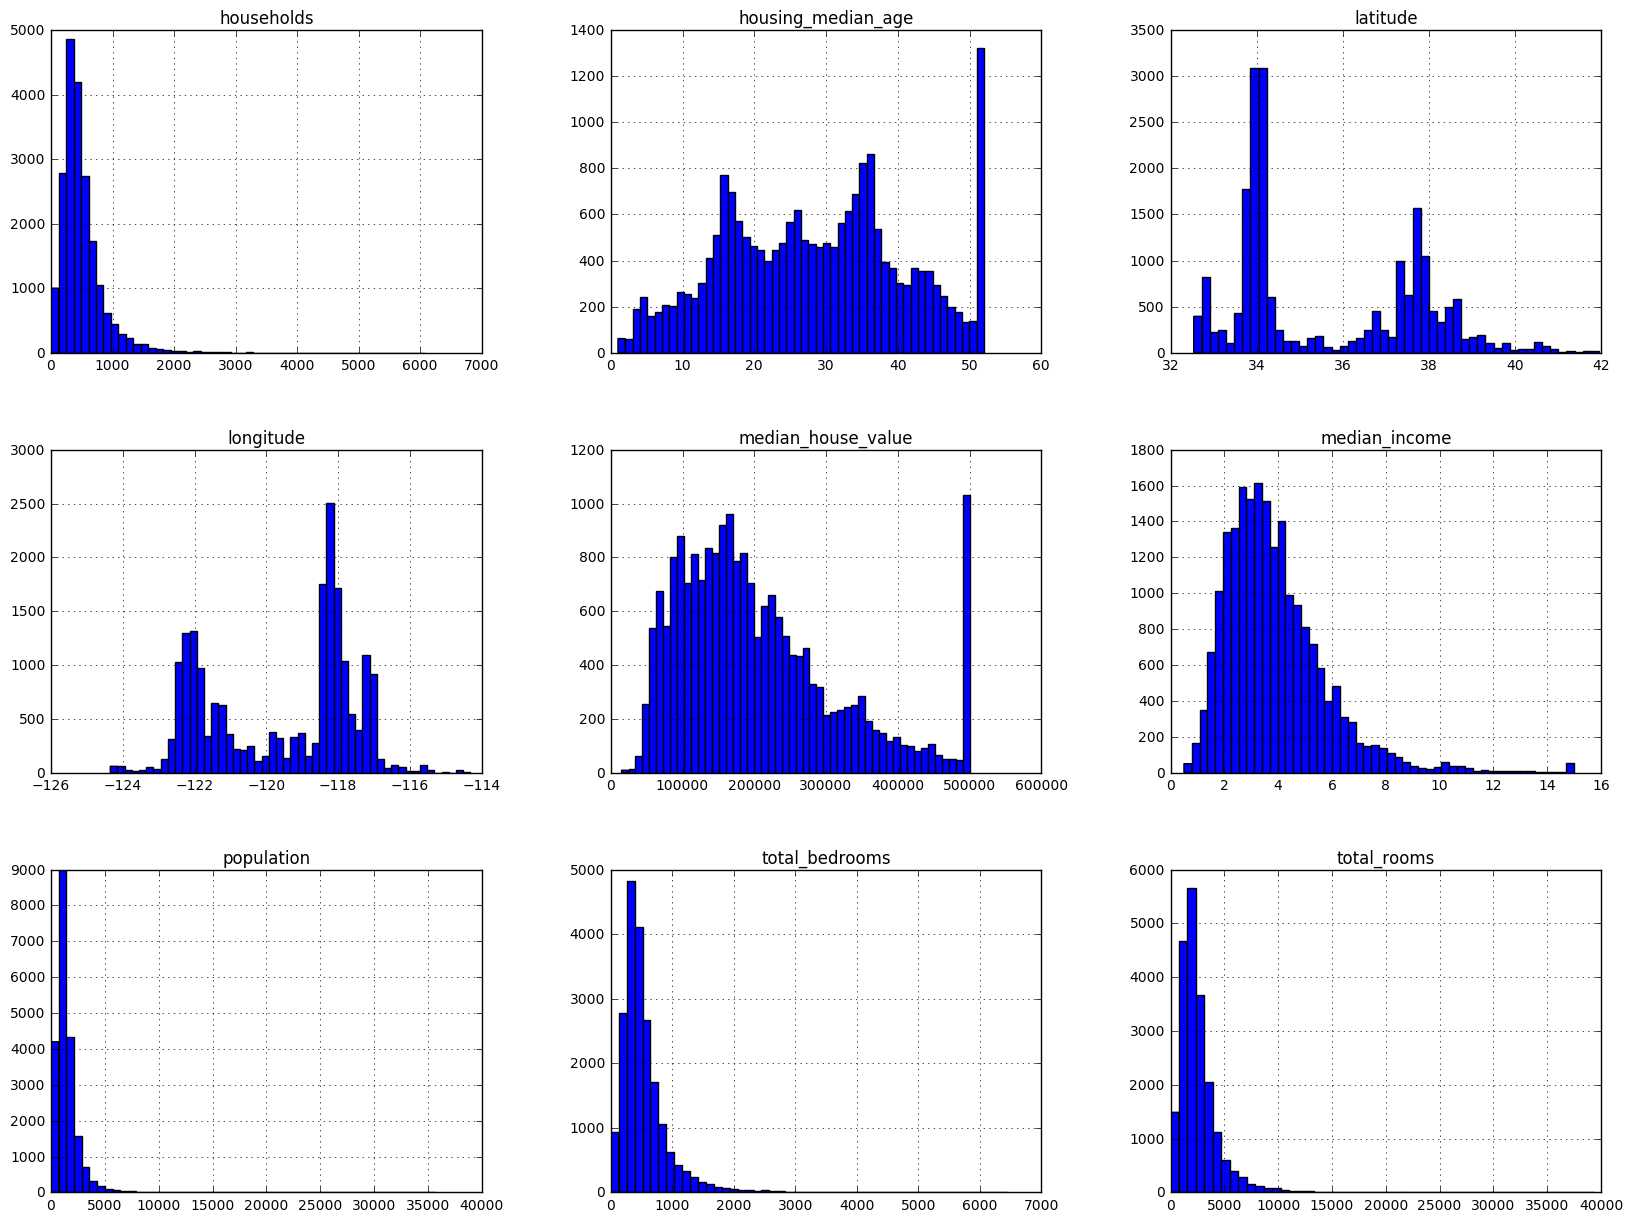

In [150]:
# visually getting a feel for our data by plotting histograms
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Create a Test Set

In [151]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [152]:
import hashlib

"""
Using each instance's identifier to decide whether or not it should go
in the test set. In this case we are computing a hash of each instance's
identifier, keeping on the last byte of the hash, and putting the instance
in the test set if this value is lower or equal to 51
"""

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [153]:
# We have to use the row id because the housing dataset doesn't have
# an indentifier column

housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [154]:
"""
If were to use the row index as a unique identifier, we would have to make
sure that new data gets appended to the end of the dataset, and no row gets
deleted. Since that is usually not possible we should try to use more stable
features to build a unique identifier.
"""

housing_with_id["id"] = housing["longitude"] *1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [155]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [156]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] <5, 5.0, inplace=True)

In [157]:
# performing stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [158]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [159]:
# validating that the proportions are similar
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [160]:
# removing the income_cat attribute so the data is back to normal
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [161]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

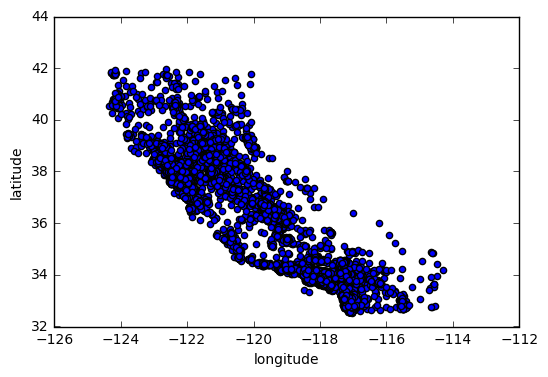

In [162]:
housing.plot(kind="scatter", x="longitude", y="latitude")

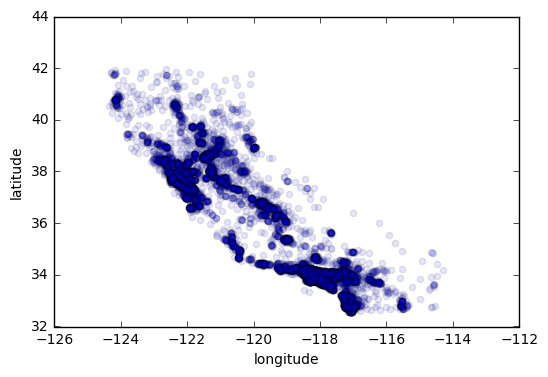

In [163]:
# trying to get a better sense of density of data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

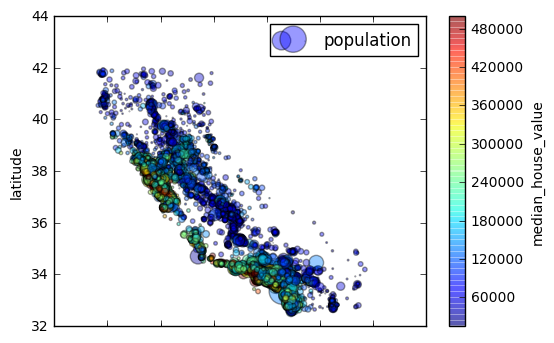

In [164]:
# Visualizing the housing prices. The radius of each circle (option s) 
# represents the district's population and the color represents the 
# price (option c)

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"), 
             colorbar=True)
plt.legend()

## Looking for Correlations

In [165]:
# computing the standard correlation coefficient between every pair
# of attributes 
corr_matrix = housing.corr()

In [166]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x137510a20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111a79b70>]], dtype=object)

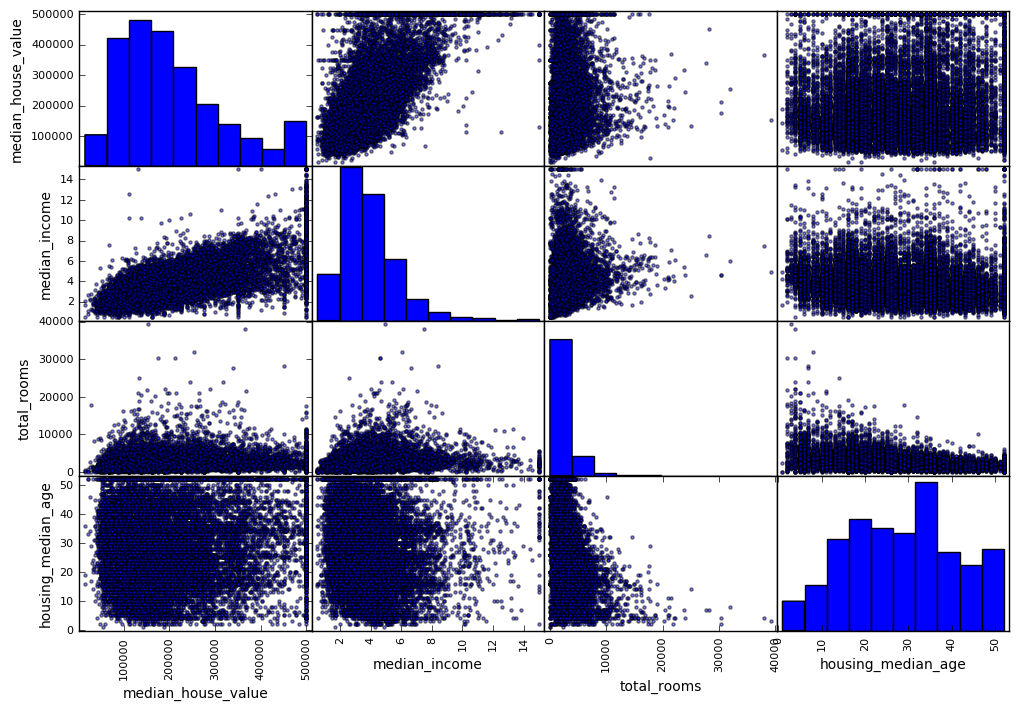

In [167]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", 
              "total_rooms", "housing_median_age"]
# plotting the promising attributes against each other
scatter_matrix(housing[attributes], figsize=(12, 8))

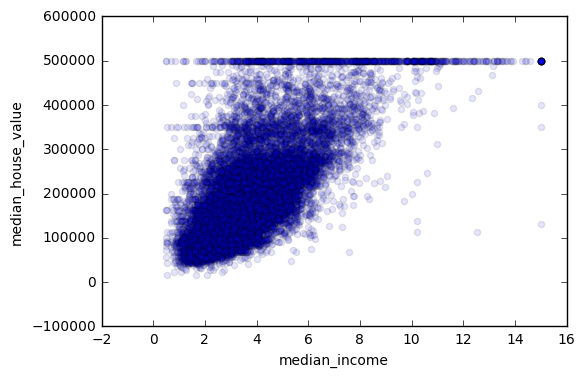

In [168]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1)

## Experimenting with Attribute Combinations

In [169]:
# creating a few more attributes
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [170]:
# getting a new correlation matrix with the new attributes
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms

In [171]:
# Getting a clean training set and seperating the predictors and labels
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In [172]:
# The total_bedrooms attribute has some missing values and we have
# three options: 
# - get rid of those districts, 
# - get rid of the whole attribute
# - set the values to some value

housing.dropna(subset=["total_bedrooms"])
housing.drop("total_bedrooms", axis=1)
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
19480     588.0
8879      317.0
13685     293.0
4937      465.0
4861      229.0
16365     951.0
19684     559.0
19234     501.0
13956     582.0
2390      495.0
11176     649.0
15614     545.0
2953      251.0
13209     409.0
6569      261.0
5825      913.0
18086     538.0
16718     945.0
13600     278.0
13989     444.0
15168     190.0
6747      563.0
7398      366.0
5562      133.0
16121     416.0
          ...  
12380     767.0
5618       24.0
10060     539.0
18067     438.0
4471      797.0
19786     300.0
9969      393.0
14621    1051.0
579       302.0
11682    1615.0
245       460.0
12130     537.0
16441     544.0
11016     428.0
19934     422.0
1364       34.0
1236      829.0
5364      272.0
11703     300.0
10356     449.0
15270     515.0
3754      373.0
12166     756.0
6003      932.0
7364      212.0
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, dt

In [173]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

In [174]:
# the median can only be computed on numerical attributes
# so we have to make a copy of the data without the 
# ocean_proximity attribute
housing_num = housing.drop("ocean_proximity", axis=1)

In [175]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [176]:
imputer.statistics_ == housing_num.median().values

array([ True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [177]:
# transforming the training set by replacing the missing values 
# with the learned medians
X = imputer.transform(housing_num)

# putting it into a dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## Handling Text and Categorical Attributes

In [178]:
# encoding the ocean_proximity attribute
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [179]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [180]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [181]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [182]:
# going from text categories to integer categories 
# then from inter categories to one-hot vectors

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

## Custom Transformers

In [183]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, househould_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no args* or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, househould_ix]
        population_per_household = X[:, population_ix] / X[:, househould_ix]
        if self.add_bedrooms_per_room:
                bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
                return np.c_[X, rooms_per_household, population_per_household,
                             bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
    

## Transformation Pipelines

In [184]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
    ])

num_pipeline.fit_transform(housing_num)

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [185]:
# SKLearn has no way of handling Panda Dataframe
# so this is a simple transformer to do so.

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [186]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [187]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [188]:
housing_prepared.shape

(16512, 16)

# Select and Train a Model 

##  Training and Evaluating on the Training Set

In [189]:
# training a linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [190]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [191]:
# measuring the regression model's RMSE on the whole training set
# using the mean_squared_error function

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

In [192]:
# trying a more coo
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [193]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Better Evaluation Using Cross-Validation 

In [194]:
# checking to see if we overfit with the Decision Tree Regression
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [195]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [ 68653.15600066  65290.56111248  70215.41735918  68594.76229784
  72110.62643596  72979.8520368   71020.30459815  70716.67689248
  77375.66970506  68642.64970389]
Mean: 70559.9676143
Standard deviation: 3066.10626889


In [196]:
# computing scores on the linear regression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


In [197]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

22390.7644618
Scores: [ 52311.2881442   49931.47443602  52470.56056512  54781.10993617
  52120.77706401  55492.98026886  50554.28180342  50068.73918382
  55220.20200208  52689.37148593]
Mean: 52564.078489
Standard deviation: 1950.13215718


# Fine Tune Your Model

## Grid Search 

In [198]:
from sklearn.model_selection import GridSearchCV

# tells SKLearn to first evaluate all 12 combinations of n_estimators
# and max_features hyperparameter values then try all 6 combinations
# of hyperparameter values in the second dict with the bootstrap
# hyperparameter set to False
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 
     'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error")

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'bootstrap': [False], 'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [199]:
# getting best combination of parameters
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [200]:
# getting best estimator directly
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [201]:
# getting all the evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63930.2536227 {'max_features': 2, 'n_estimators': 3}
55238.0109492 {'max_features': 2, 'n_estimators': 10}
53146.807653 {'max_features': 2, 'n_estimators': 30}
60152.1527711 {'max_features': 4, 'n_estimators': 3}
52828.0977864 {'max_features': 4, 'n_estimators': 10}
50766.7192193 {'max_features': 4, 'n_estimators': 30}
59011.7529757 {'max_features': 6, 'n_estimators': 3}
52128.560236 {'max_features': 6, 'n_estimators': 10}
50192.9610607 {'max_features': 6, 'n_estimators': 30}
59118.1260849 {'max_features': 8, 'n_estimators': 3}
51952.7781711 {'max_features': 8, 'n_estimators': 10}
50062.9167125 {'max_features': 8, 'n_estimators': 30}
63546.0727581 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54428.3722258 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59955.2742351 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52663.243191 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58278.3181836 {'bootstrap': False, 'max_features': 4, 'n_estimato

## Randomized Search 

In [269]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}

forest_reg = RandomForestRegressor()
randomized_search = RandomizedSearchCV(forest_reg, 
                                       param_distributions=param_distribs,
                                       n_iter=10,
                                       cv=5,
                                       scoring="neg_mean_squared_error")
randomized_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x137905048>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x137905668>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [270]:
cvres = randomized_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

54476.8494638 {'max_features': 1, 'n_estimators': 161}
49137.7008347 {'max_features': 6, 'n_estimators': 166}
49414.7350136 {'max_features': 5, 'n_estimators': 85}
54539.3908047 {'max_features': 1, 'n_estimators': 123}
58615.4262946 {'max_features': 2, 'n_estimators': 6}
54953.3637319 {'max_features': 4, 'n_estimators': 6}
50831.3625287 {'max_features': 3, 'n_estimators': 64}
52190.914068 {'max_features': 2, 'n_estimators': 57}
54639.8535584 {'max_features': 1, 'n_estimators': 72}
54451.9869666 {'max_features': 1, 'n_estimators': 139}


## Analyze the Best Models and Their Errors 

In [214]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.11073250e-02,   6.58931228e-02,   4.25538343e-02,
         1.56047518e-02,   1.39322931e-02,   1.51003497e-02,
         1.48496026e-02,   3.46990832e-01,   4.64112799e-02,
         1.16220015e-01,   8.04199942e-02,   8.34818948e-03,
         1.56716265e-01,   8.12740339e-05,   2.31187165e-03,
         3.45900015e-03])

In [215]:
# displaying importance scores next to their corresponding attribute names
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3469908316095785, 'median_income'),
 (0.15671626497325733, 'INLAND'),
 (0.11622001467100639, 'pop_per_hhold'),
 (0.08041999421700613, 'bedrooms_per_room'),
 (0.071107324967539284, 'longitude'),
 (0.065893122849246491, 'latitude'),
 (0.046411279933930218, 'rooms_per_hhold'),
 (0.042553834268773828, 'housing_median_age'),
 (0.015604751798006669, 'total_rooms'),
 (0.015100349732050081, 'population'),
 (0.014849602611202639, 'households'),
 (0.013932293055655649, 'total_bedrooms'),
 (0.0083481894805794502, '<1H OCEAN'),
 (0.0034590001504182944, 'NEAR OCEAN'),
 (0.002311871647860867, 'NEAR BAY'),
 (8.1274033888130063e-05, 'ISLAND')]

## Evaluate Your System on the Test Set 

In [230]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48374.416518653394

# Exercises

## Exercise 1 

In [271]:
from sklearn.svm import SVR
svm_reg = SVR()
param_grid = [
    {
        'kernel': ['rbf'],
        'C': [1.0, 2.5, 3.75, 10.0, 24.6, 9.7],
        'gamma': [(1/16), (1/8), (1/4), (1/2)]
    },
    {
        'kernel': ['linear'],
        'C': [1.0, 2.5, 3.75, 10.0, 24.6, 9.7]
    }
]

grid_search = GridSearchCV(svm_reg,
                           param_grid,
                           cv=5,
                           scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)

# getting all the evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

118634.224352 {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.0625}
118651.940923 {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.125}
118740.664019 {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.25}
118832.339802 {'C': 1.0, 'kernel': 'rbf', 'gamma': 0.5}
118217.572648 {'C': 2.5, 'kernel': 'rbf', 'gamma': 0.0625}
118257.128556 {'C': 2.5, 'kernel': 'rbf', 'gamma': 0.125}
118468.703787 {'C': 2.5, 'kernel': 'rbf', 'gamma': 0.25}
118709.346993 {'C': 2.5, 'kernel': 'rbf', 'gamma': 0.5}
117874.888869 {'C': 3.75, 'kernel': 'rbf', 'gamma': 0.0625}
117923.7697 {'C': 3.75, 'kernel': 'rbf', 'gamma': 0.125}
118236.564255 {'C': 3.75, 'kernel': 'rbf', 'gamma': 0.25}
118593.737606 {'C': 3.75, 'kernel': 'rbf', 'gamma': 0.5}
116146.571595 {'C': 10.0, 'kernel': 'rbf', 'gamma': 0.0625}
116332.998423 {'C': 10.0, 'kernel': 'rbf', 'gamma': 0.125}
117146.065853 {'C': 10.0, 'kernel': 'rbf', 'gamma': 0.25}
118037.764866 {'C': 10.0, 'kernel': 'rbf', 'gamma': 0.5}
112394.373055 {'C': 24.6, 'kernel': 'rbf', 'gamma': 0.0625}
112817.283661 

## Exercise 2 

In [ ]:
from scipy.stats import expon
svm_reg = SVR()
param_distribs1 = {
        'kernel': ['rbf'],
        'C': expon(scale=100),
        'gamma': expon(scale=.1)
}
param_distribs2 = {
        'kernel': ['linear'],
        'C': expon(scale=100),
}


randomized_search = RandomizedSearchCV(svm_reg,
                                       param_distribs1,
                                       n_iter=10,
                                       cv=5,
                                       scoring="neg_mean_squared_error")
randomized_search.fit(housing_prepared, housing_labels)

# getting all the evaluation scores
cvres = randomized_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

## Exercise 3  and 4

In [261]:
%xmode Plain
%pdb off

Exception reporting mode: Plain
Automatic pdb calling has been turned OFF


In [268]:
from sklearn.feature_selection import SelectFromModel

selection = Pipeline([
        ('feature_selection', SelectFromModel(RandomForestRegressor(), threshold=0.01)),
        ('estimator', RandomForestRegressor())
    ])

selection.fit(housing_prepared, housing_labels).predict(housing_prepared)




array([ 281790. ,  319170. ,  196140. , ...,   98600. ,  200040. ,
        483110.7])